# Machine Learning meets Climate Change

In [10]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import folium
import imageio
from tqdm import tqdm_notebook
from folium.plugins import MarkerCluster
import imageio
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import scipy
from itertools import product
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf

plt.style.use('ggplot')
plt.rcParams['font.family'] = 'sans-serif' 
plt.rcParams['font.serif'] = 'Ubuntu' 
plt.rcParams['font.monospace'] = 'Ubuntu Mono' 
plt.rcParams['font.size'] = 14 
plt.rcParams['axes.labelsize'] = 12 
plt.rcParams['axes.labelweight'] = 'bold' 
plt.rcParams['axes.titlesize'] = 12 
plt.rcParams['xtick.labelsize'] = 12 
plt.rcParams['ytick.labelsize'] = 12 
plt.rcParams['legend.fontsize'] = 12 
plt.rcParams['figure.titlesize'] = 12 
plt.rcParams['image.cmap'] = 'jet' 
plt.rcParams['image.interpolation'] = 'none' 
plt.rcParams['figure.figsize'] = (12, 10) 
plt.rcParams['axes.grid']=True
plt.rcParams['lines.linewidth'] = 2 
plt.rcParams['lines.markersize'] = 8
colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd: goldenrod', 'xkcd:cadet blue',
'xkcd:scarlet']

In [11]:
data = pd.read_csv('CleanedGlobalLandTemperaturesByMajorCity.csv')

# Data Visualization

In [12]:
city_data = data

In [13]:
data.head()

,Unnamed: 0,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,48243,1921-01-01,6.9908,1.021,Changchun,China,44.20N,125.22E
1,48244,1921-02-01,11.9930,0.593,Changchun,China,44.20N,125.22E
2,48245,1921-03-01,24.1394,0.278,Changchun,China,44.20N,125.22E
3,48246,1921-04-01,43.6406,0.700,Changchun,China,44.20N,125.22E
4,48247,1921-05-01,59.3456,0.480,Changchun,China,44.20N,125.22E


In [14]:
data.shape

(5565, 8)

# Create List of Cities

In [15]:
top_5_coldest = list(data.City.unique())
top_5_coldest

['Changchun', 'Harbin', 'Montreal', 'Moscow', 'Saint Petersburg']

# Create Year Month day and weekday columns to fit machine learning models

In [17]:
city_data = city_data.reset_index()

In [18]:
city_data = city_data.drop(columns=['index'])

In [19]:
city_data.dt = pd.to_datetime(city_data.dt)

In [21]:
YEAR = []
MONTH = []
DAY = []
WEEKDAY = []
for i in range(len(city_data)):
    WEEKDAY.append(city_data.dt[i].weekday())
    DAY.append(city_data.dt[i].day)
    MONTH.append(city_data.dt[i].month)
    YEAR.append(city_data.dt[i].year)

In [22]:
city_data['Year'] = YEAR
city_data['Month'] = MONTH
city_data['Day'] = DAY 
city_data['Weekday'] = WEEKDAY

In [23]:
change_year_index = []
change_year = []
year_list = city_data['Year'].tolist()
for y in range(0,len(year_list)-1):
    if year_list[y]!=year_list[y+1]:
        change_year.append(year_list[y+1])
        change_year_index.append(y+1)

In [24]:
city_data.loc[change_year_index].head()

,Unnamed: 0,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,Year,Month,Day,Weekday
12,48255,1922-01-01,-9.8896,1.200,Changchun,China,44.20N,125.22E,1922,1,1,6
24,48267,1923-01-01,-0.1480,0.626,Changchun,China,44.20N,125.22E,1923,1,1,0
36,48279,1924-01-01,0.6224,0.570,Changchun,China,44.20N,125.22E,1924,1,1,1
48,48291,1925-01-01,0.6746,0.765,Changchun,China,44.20N,125.22E,1925,1,1,3
60,48303,1926-01-01,1.9004,0.891,Changchun,China,44.20N,125.22E,1926,1,1,4


In [25]:
x_ticks_year_list=np.linspace(min(year_list),max(year_list),10).astype(int)
change_year_index = np.array(change_year_index)
x_ticks_year_index = []
for i in range(1,len(x_ticks_year_list)):
    x_ticks_year_index.append(change_year_index[np.where(np.array(change_year)==x_ticks_year_list[i])][0])

In [26]:
last_year_data = city_data[city_data.Year>=2010].reset_index().drop(columns=['index'])
P = np.linspace(0,len(last_year_data)-1,5).astype(int)

In [27]:
def get_timeseries(start_year,end_year):
    last_year_data = city_data[(city_data.Year>=start_year) & (city_data.Year<=end_year)].reset_index().drop(columns=['index'])
    return last_year_data

In [28]:
def plot_timeseries(start_year,end_year):
    last_year_data = get_timeseries(start_year,end_year)
    P = np.linspace(0,len(last_year_data)-1,5).astype(int)
    plt.plot(last_year_data.AverageTemperature,marker='.',color='firebrick')
    plt.xticks(np.arange(0,len(last_year_data),1)[P],last_year_data.dt.loc[P],rotation=60)
    plt.xlabel('Date (Y/M/D)')
    plt.ylabel('Average Temperature')

In [29]:
def plot_from_data(data,time,c='firebrick',with_ticks=True,label=None):
    time = time.tolist()
    data = np.array(data.tolist())
    P = np.linspace(0,len(data)-1,5).astype(int)
    time = np.array(time)
    if label==None:
        plt.plot(data,marker='.',color=c)
    else:
        plt.plot(data,marker='.',color=c,label=label)
    if with_ticks==True:
        plt.xticks(np.arange(0,len(data),1)[P],time[P],rotation=60)
    plt.xlabel('Date (Y/M/D)')
    plt.ylabel('Average Temperature')

C:\Users\trevo\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


(2.0, 22.0)

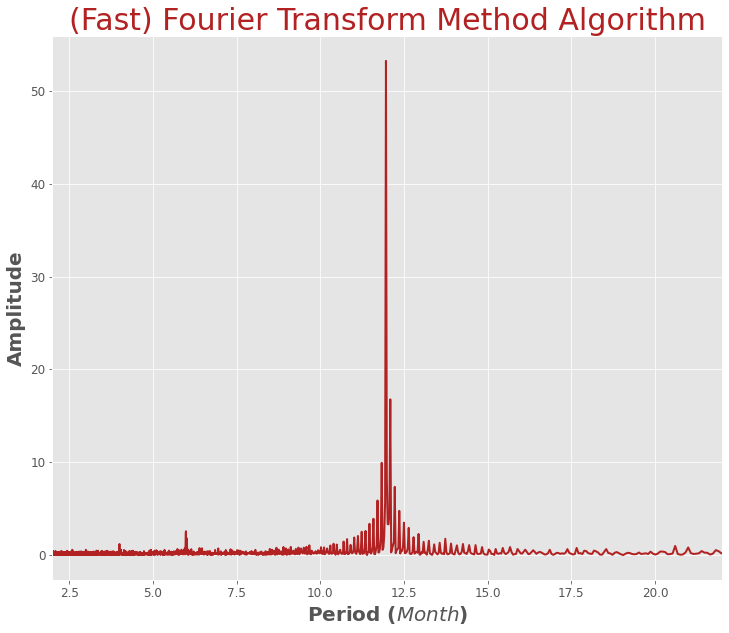

In [30]:
FFT = np.fft.fft(city_data.AverageTemperature)
FFT_abs = np.abs(FFT)
new_N=int(len(FFT)/2) 
f_nat=1
new_X = np.linspace(0, f_nat/2, new_N, endpoint=True)
new_X = 1/new_X
plt.plot(new_X,2*FFT_abs[0:int(len(FFT)/2.)]/len(new_X),color='firebrick')
plt.xlabel('Period ($Month$)',fontsize=20)
plt.ylabel('Amplitude',fontsize=20)
plt.title('(Fast) Fourier Transform Method Algorithm',fontsize=30,color='firebrick')
plt.grid(True)
plt.xlim(2,22)

# Checking on Stationarity

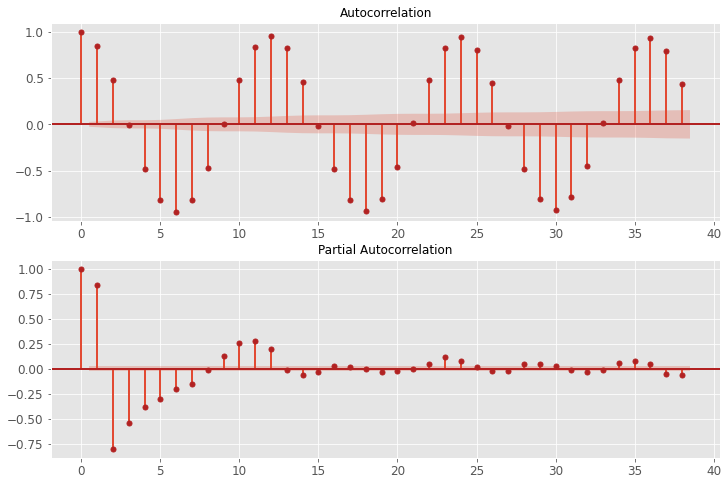

In [31]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(city_data.AverageTemperature, ax=ax1,color ='firebrick')
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(city_data.AverageTemperature, ax=ax2,color='firebrick')

In [32]:
result = adfuller(city_data.AverageTemperature)
print('ADF Statistic on the entire dataset: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic on the entire dataset: -8.389662916338134
p-value: 2.385568286334261e-13
Critical Values:
	1%: -3.431532848940655
	5%: -2.8620627023707046
	10%: -2.5670482332064295


In [33]:
result = adfuller(city_data.AverageTemperature[0:120])
print('ADF Statistic on the first decade: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic on the first decade: -2.050460990470776
p-value: 0.26489501529313025
Critical Values:
	1%: -3.4924012594942333
	5%: -2.8886968193364835
	10%: -2.5812552709190673


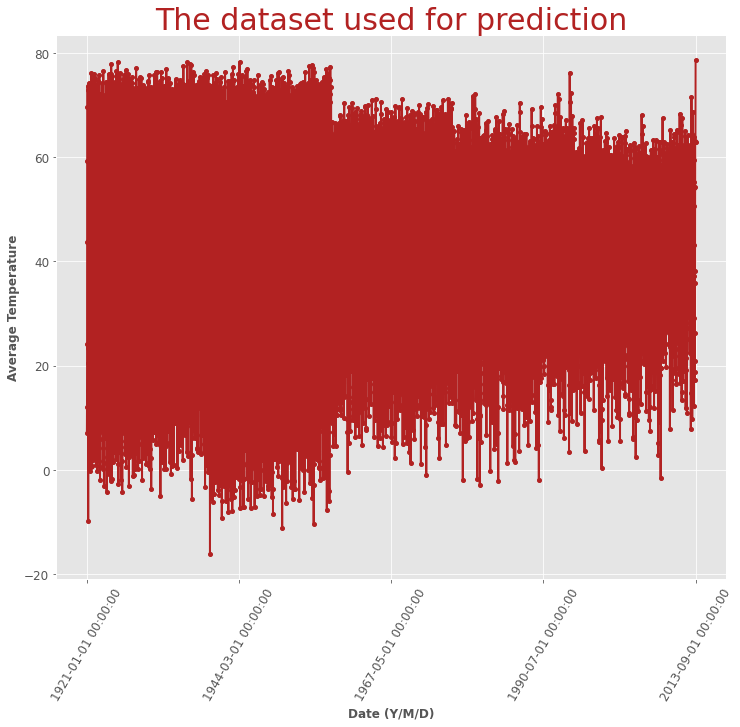

In [34]:
plt.title('The Whole dataset used for prediction', fontsize=30,color='firebrick')
plot_timeseries(1921,2013)

In [35]:
temp = get_timeseries(1921,2013)
N = len(temp.AverageTemperature)
split = 0.95
training_size = round(split*N)
test_size = round((1-split)*N)
series = temp.AverageTemperature[:training_size]
date = temp.dt[:training_size]
test_series = temp.AverageTemperature[len(date)-1:len(temp)]
test_date = temp.dt[len(date)-1:len(temp)]
#test_date = test_date.reset_index().dt
#test_series = test_series.reset_index().AverageTemperature

In [36]:
test_date

5286   1990-07-01
5287   1990-08-01
5288   1990-09-01
5289   1990-10-01
5290   1990-11-01
          ...    
5560   2013-05-01
5561   2013-06-01
5562   2013-07-01
5563   2013-08-01
5564   2013-09-01
Name: dt, Length: 279, dtype: datetime64[ns]

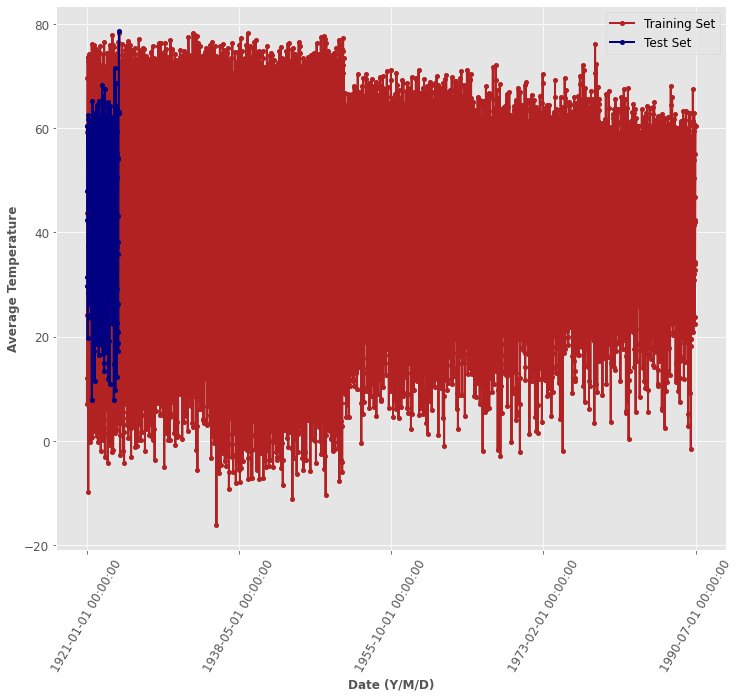

In [37]:
plot_from_data(series,date,label='Training Set')
plot_from_data(test_series,test_date,'navy',with_ticks=False,label='Test Set')
plt.legend()

# Finding the optimal parameters

In [38]:
def optimize_ARIMA(order_list, exog):
    """
        Return dataframe with parameters and corresponding AIC
        
        order_list - list with (p, d, q) tuples
        exog - the exogenous variable
    """
    
    results = []
    
    for order in tqdm_notebook(order_list):
        #try: 
        model = SARIMAX(exog, order=order).fit(disp=-1)
    #except:
    #        continue
            
        aic = model.aic
        results.append([order, model.aic])
    #print(results)
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [39]:
ps = range(0, 10, 1)
d = 0
qs = range(0, 10, 1)

# Create a list with all possible combination of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)

order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, d)
    each = tuple(each)
    order_list.append(each)
    
result_d_0 = optimize_ARIMA(order_list, exog = series)


C:\Users\trevo\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\trevo\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\trevo\anaconda3\envs\mlenv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\trevo\anaconda3\envs\mlenv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\trevo\anaconda3\envs\mlenv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\trevo\anaconda3\envs\mlenv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check m

C:\Users\trevo\anaconda3\envs\mlenv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\trevo\anaconda3\envs\mlenv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\trevo\anaconda3\envs\mlenv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\trevo\anaconda3\envs\mlenv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\trevo\anaconda3\envs\mlenv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\trevo\

In [40]:
result_d_0.head()

,"(p, d, q)",AIC
0,"(9, 0, 7)",30535.655591
1,"(8, 0, 9)",30539.073431
2,"(9, 0, 9)",30545.105794
3,"(9, 0, 6)",30570.370453
4,"(8, 0, 6)",30593.247335


In [41]:
ps = range(0, 10, 1)
d = 1
qs = range(0, 10, 1)

# Create a list with all possible combination of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)

order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, d)
    each = tuple(each)
    order_list.append(each)
    
result_d_1 = optimize_ARIMA(order_list, exog = series)

result_d_1

C:\Users\trevo\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\trevo\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\trevo\anaconda3\envs\mlenv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\trevo\anaconda3\envs\mlenv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\trevo\anaconda3\envs\mlenv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\trevo\anaconda3\envs\mlenv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check m

C:\Users\trevo\anaconda3\envs\mlenv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\trevo\anaconda3\envs\mlenv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\trevo\anaconda3\envs\mlenv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\trevo\anaconda3\envs\mlenv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\trevo\anaconda3\envs\mlenv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\trevo\

,"(p, d, q)",AIC
0,"(9, 1, 8)",30515.863662
1,"(9, 1, 9)",30521.357782
2,"(8, 1, 8)",30522.573299
3,"(8, 1, 7)",30524.374793
4,"(7, 1, 9)",30527.858172
...,...,...
95,"(0, 1, 2)",38331.823942
96,"(1, 1, 0)",38344.660217
97,"(1, 1, 2)",38810.023083
98,"(0, 1, 1)",39411.452768


In [42]:
result_d_1.head()

,"(p, d, q)",AIC
0,"(9, 1, 8)",30515.863662
1,"(9, 1, 9)",30521.357782
2,"(8, 1, 8)",30522.573299
3,"(8, 1, 7)",30524.374793
4,"(7, 1, 9)",30527.858172


In [43]:
final_result = result_d_0.append(result_d_1)

In [44]:
best_models = final_result.sort_values(by='AIC', ascending=True).reset_index(drop=True).head()

In [45]:
best_model_params_0 = best_models[best_models.columns[0]][0]
best_model_params_1 = best_models[best_models.columns[0]][1]

In [46]:
temp = get_timeseries(1921,2013)
# N = len(temp.AverageTemperature)
# split = 0.95
# training_size = round(split*N)
# test_size = round((1-split)*N)
# series = temp.AverageTemperature[:training_size]
# date = temp.dt[:training_size]
# test_series = temp.AverageTemperature[len(date)-1:len(temp)]
# test_date = temp.dt[len(date)-1:len(temp)]
#df is original datframe
# cities = list(data['City'].unique())
cities = ["Harbin","Changchun","Moscow","Montreal","Saint Petersburg"]
for city in cities:
    series = data[data.City == city]["AverageTemperature"]
    N = len(series)
    split = 0.95
    training_size = round(split*N)
    test_size = round((1-split)*N) ##Not needed here but needed when you want to forecast
    series = series[:training_size]
    best_model_0 = SARIMAX(series, order=best_model_params_0).fit()
    best_model_1 = SARIMAX(series, order=best_model_params_1).fit()
print(best_model_0.summary())
print(best_model_1.summary())

C:\Users\trevo\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\trevo\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\trevo\anaconda3\envs\mlenv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\trevo\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\trevo\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: Value

                               SARIMAX Results                                
Dep. Variable:     AverageTemperature   No. Observations:                 1057
Model:               SARIMAX(9, 1, 8)   Log Likelihood               -3088.753
Date:                Sun, 14 Nov 2021   AIC                           6213.506
Time:                        10:23:40   BIC                           6302.826
Sample:                             0   HQIC                          6247.364
                               - 1057                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1132      0.217     -5.125      0.000      -1.539      -0.688
ar.L2         -0.1410      0.133     -1.058      0.290      -0.402       0.120
ar.L3          0.6204      0.113      5.510      0.0

C:\Users\trevo\anaconda3\envs\mlenv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


# Model (2,1,5) results:

C:\Users\trevo\anaconda3\envs\mlenv\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


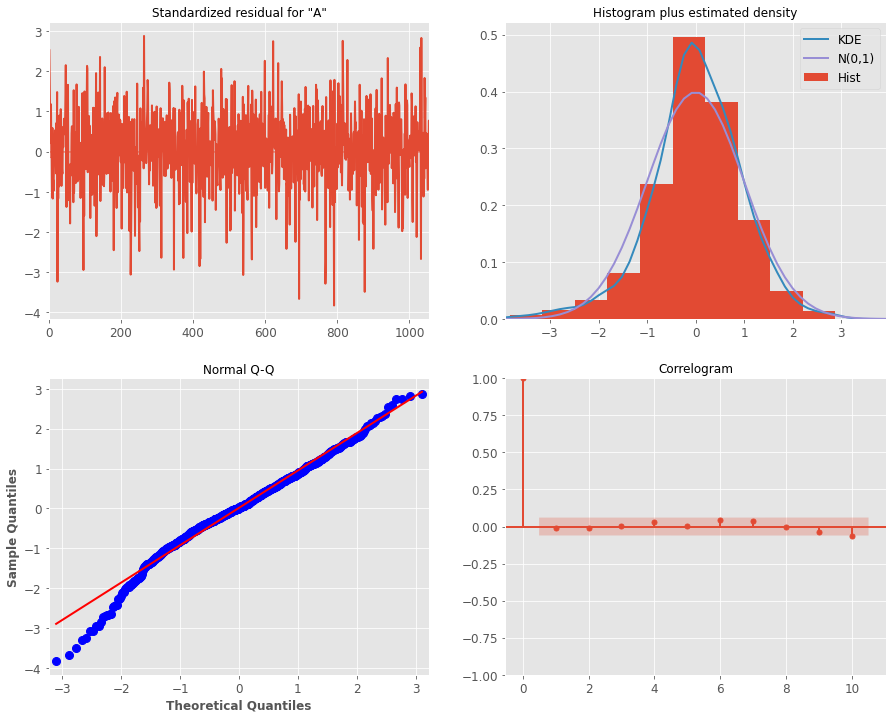

In [47]:
best_model_0.plot_diagnostics(figsize=(15,12))
plt.show()

# Model (2,1,6) results:

C:\Users\trevo\anaconda3\envs\mlenv\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


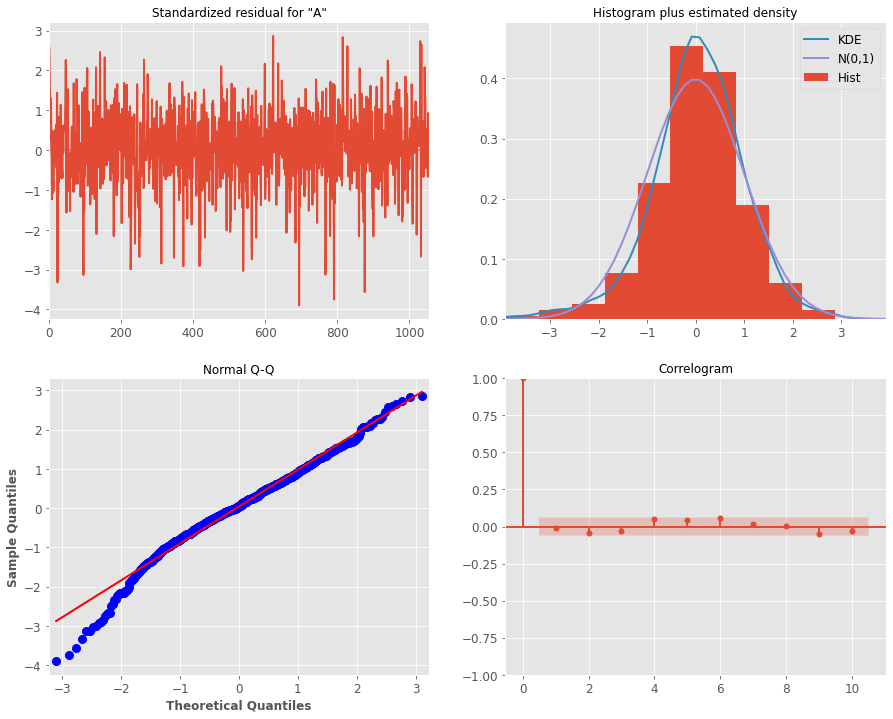

In [48]:
best_model_1.plot_diagnostics(figsize=(15,12))
plt.show()

## Forecasting

In [49]:
fore_l= test_size-1
forecast_1 = best_model_0.get_prediction(start=test_size, end=test_size+fore_l)
forec = forecast_1.predicted_mean
ci = forecast_1.conf_int(alpha=0.05)

s_forecast_1 = best_model_1.get_prediction(start=test_size, end=test_size+fore_l)
s_forec = s_forecast_1.predicted_mean
s_ci = s_forecast_1.conf_int(alpha=0.05)


In [50]:
forecast = best_model_0.predict(start=test_size, end=test_size+fore_l-1)
forecast = pd.DataFrame(forecast)
s_forecast = best_model_1.predict(start=test_size, end=test_size+fore_l-1)
s_forecast = pd.DataFrame(s_forecast)

In [53]:
error_test=city_data.loc[test_date[1:].index.tolist()].AverageTemperatureUncertainty
index_test = test_date[1:].index.tolist()
test_set = test_series[1:]

In [54]:
lower_test = test_set-error_test
upper_test = test_set+error_test

In [55]:
s_forecast = s_forecast.reset_index()
s_forecast['index'] = city_data.AverageTemperature[training_size:training_size+fore_l].index
s_forecast.set_index("index",drop = True, inplace = True)

forecast = forecast.reset_index()
forecast['index'] = city_data.AverageTemperature[training_size:training_size+fore_l].index
forecast.set_index("index",drop = True, inplace = True)

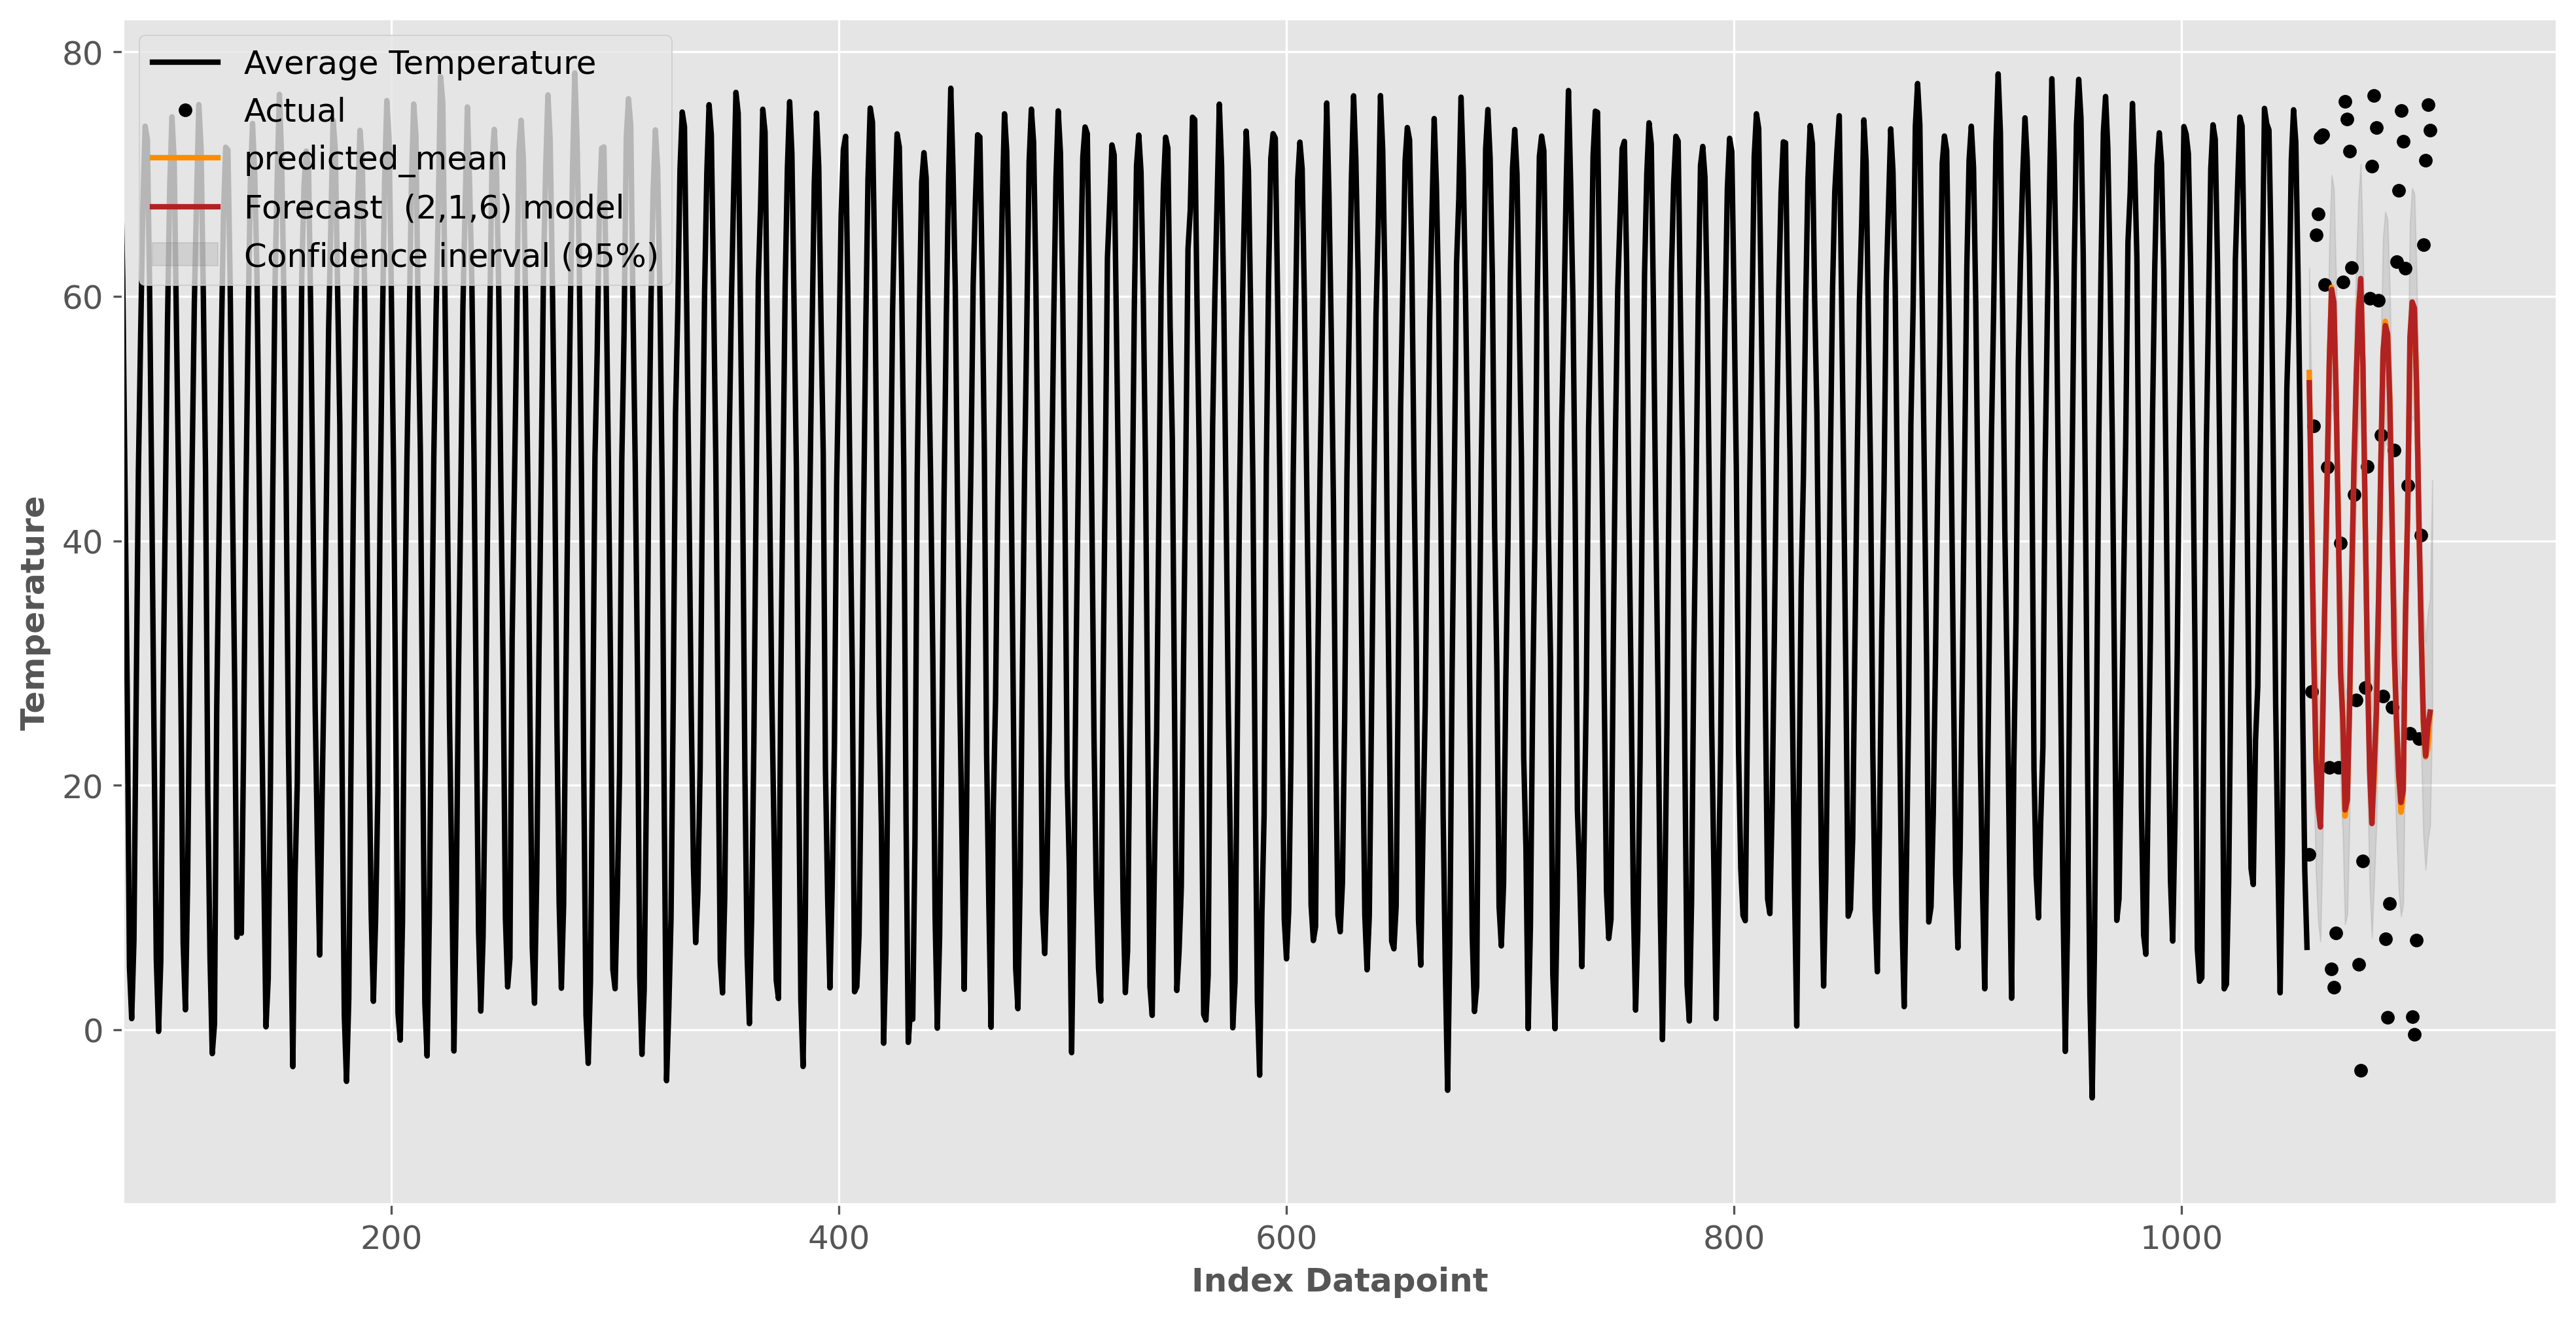

In [56]:
fig, ax = plt.subplots(figsize=(16,8), dpi=300)
x0 = city_data.AverageTemperature.index[0:training_size]
x1=city_data.AverageTemperature.index[training_size:training_size+fore_l+1]
#ax.fill_between(forec, ci['lower Load'], ci['upper Load'])
plt.plot(x0, city_data.AverageTemperature[0:training_size],'k', label = 'Average Temperature')

plt.plot(city_data.AverageTemperature[training_size:training_size+fore_l], '.k', label = 'Actual')

# forec = pd.DataFrame(forec, columns=['f'], index = x1)
forecast.plot(ax=ax,color = 'Darkorange',label = 'Forecast (d = 2)')
#ax.fill_between(x1, ci['lower AverageTemperature'], ci['upper AverageTemperature'],alpha=0.2, label = 'Confidence inerval (95%)',color='grey')

# s_forec = pd.DataFrame(s_forecast, columns=['f'], index = x1)
s_forecast.predicted_mean.plot(color = 'firebrick',label = 'Forecast  (2,1,6) model')
ax.fill_between(x1, s_ci['lower AverageTemperature'], s_ci['upper AverageTemperature'],alpha=0.2, label = 'Confidence inerval (95%)',color='grey')


plt.legend(loc = 'upper left')
plt.xlim(80,)
plt.xlabel('Index Datapoint')
plt.ylabel('Temperature')
plt.show()

In [57]:
s_forecast

,predicted_mean
index,
1057,52.942006
1058,42.541392
1059,30.767683
1060,22.179865
1061,18.237252
1062,16.590249
1063,24.967634
1064,35.724658
1065,44.969994


ValueError: operands could not be broadcast together with shapes (56,) (278,) 

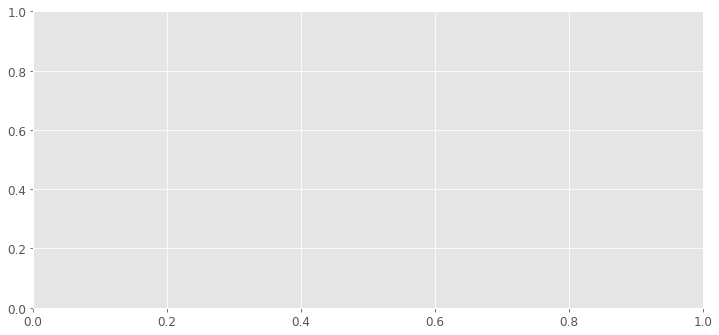

In [58]:
#plt.plot(forec)
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
plt.fill_between(x1, lower_test, upper_test,alpha=0.2, label = 'Test set error range',color='navy')
plt.plot(test_set,marker='.',label="Actual",color='navy')
plt.plot(forec,marker='d',label="Forecast",color='firebrick')
plt.xlabel('Index Datapoint')
plt.ylabel('Temperature')
#plt.fill_between(x1, s_ci['lower AverageTemperature'], s_ci['upper AverageTemperature'],alpha=0.3, label = 'Confidence inerval (95%)',color='firebrick')
plt.legend()
plt.subplot(2,1,2)
#plt.fill_between(x1, lower_test, upper_test,alpha=0.2, label = 'Test set error range',color='navy')
plt.plot(test_set,marker='.',label="Actual",color='navy')
plt.plot(s_forec,marker='d',label="Forecast",color='firebrick')
plt.fill_between(x1, ci['lower AverageTemperature'], ci['upper AverageTemperature'],alpha=0.3, label = 'Confidence inerval (95%)',color='firebrick')
plt.legend()
plt.xlabel('Index Datapoint')
plt.ylabel('Temperature')

KeyError: 'f'

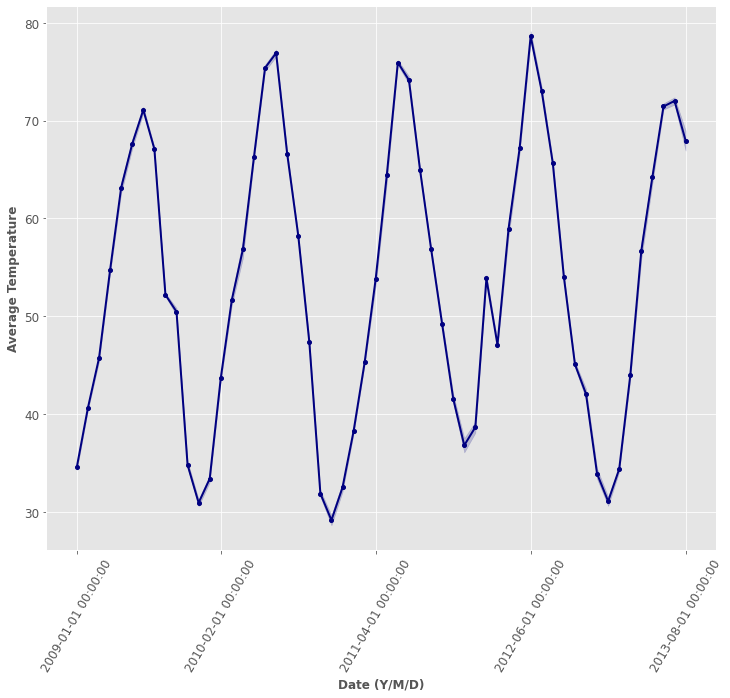

In [91]:
plt.fill_between(np.arange(0,len(test_set),1), lower_test, upper_test,alpha=0.2, label = 'Test set error range',color='navy')
plot_from_data(test_set,test_date,c='navy',label='Actual')
plot_from_data(forec['f'],test_date,c='firebrick',label='Forecast')
plt.legend(loc=2)